In [0]:
!pip install higra

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import data, img_as_float
import imageio


import higra as hg

In [0]:
#Helper functions
import time

def imshow(image, click_event=None):
    import matplotlib.pyplot as plt
    dpi = 80
    margin = 0.5  # (5% of the width/height of the figure...)
    h, w = image.shape[:2]

    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * w / dpi, (1 + margin) * h / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([0, 0, 1, 1])

    ax.imshow(image, interpolation='none')
    
    plt.axis('off')
    plt.show()
    
    return fig, ax   


def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()


def toc():
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is ", str(time.time() - startTime_for_tictoc), " seconds.")
    else:
        print("Toc: start time not set")
        

Image size: (303, 384)


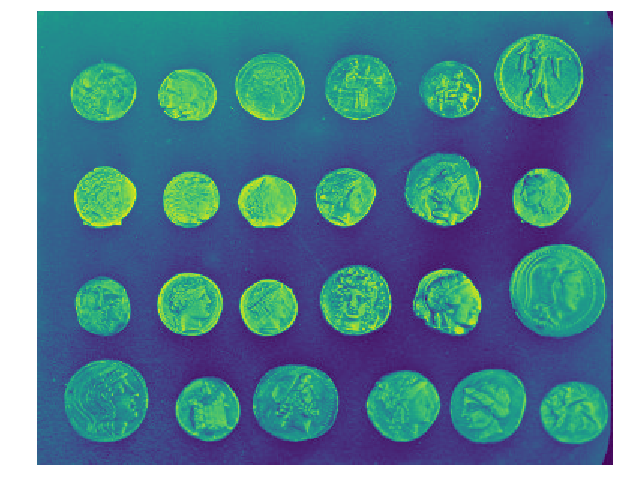

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f1a4eb32588>)

In [0]:
#Some images
def moon():
  #cat: image = im = imageio.imread('imageio:chelsea.png')
  image =  imageio.imread('imageio:moon.png')
  return image

def ellipse():
  x =  np.arange(20)
  y =  np.arange(20)
  x0 = y0 = 10
  a = b = 5
  ellipse = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1
  xgrid, ygrid = np.meshgrid(x, y)
  image = np.zeros((20,20), dtype=np.float)
  image[ellipse < 1.0] = 1
  return image

#image = moon()
image = data.coins()
# switch to float to avoid numerical issue with uint8
image = img_as_float(image)
# discard the color channel (if any)
size = image.shape[:2]
print("Image size:", size)
imshow(image)

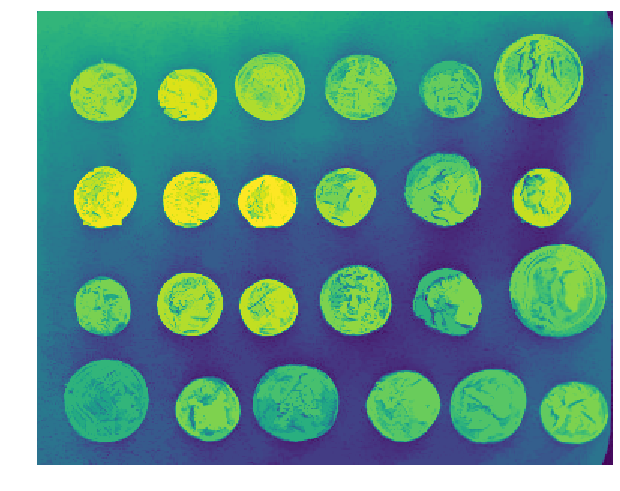

In [0]:
#Build the max tree
graph = hg.get_4_adjacency_graph(size)
tt1 , aa1 = hg.component_tree_max_tree(graph, image)
#Remove small components
area = hg.attribute_area(tt1)
condRemoval = area < 500
filtered_a1 = hg.reconstruct_leaf_data(tt1,aa1, condRemoval)
#filtered_a1 = hg.reconstruct_leaf_data(t1,a1)
imshow(np.reshape(filtered_a1, size))
#Now the max tree of the filtered image
t1 , a1 = hg.component_tree_max_tree(graph, filtered_a1)


In [0]:
# Circularity is 1 for a disk, 0 if not
def circularity(tree, size):
  emb = hg.EmbeddingGrid2d(size)
  coord = emb.lin2grid(np.arange(tree.num_leaves()))
    
  m = np.zeros((tree.num_leaves(), 6), dtype=np.float64)
  m[:, 0] = 1
  m[:, 1] = coord[:, 0]
  m[:, 2] = coord[:, 1]
  m[:, 3] = coord[:, 0] * coord[:, 1]
  m[:, 4] = coord[:, 0] * coord[:, 0]
  m[:, 5] = coord[:, 1] * coord[:, 1]
  m = hg.accumulate_sequential(tree, m, hg.Accumulators.sum)
  m00 = m[:, 0]
  m10 = m[:, 1]
  m01 = m[:, 2]
  m11 = m[:, 3]
  m20 = m[:, 4]
  m02 = m[:, 5]
  xmean = m10 / m00
  ymean = m01 / m00
  xvar = m20 / m00 - xmean * xmean
  yvar = m02 / m00 - ymean * ymean
  xycovar = m11 / m00 - xmean*ymean
  lambda1 = np.maximum(0, 0.5 * (xvar + yvar + np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
  lambda2 = np.maximum(0, 0.5 * (xvar + yvar - np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
  return np.nan_to_num(lambda2[tree.num_leaves():] / lambda1[tree.num_leaves():])

circ = circularity(t1, size)
print(circ)

[0.70969449 0.719625   0.74395793 ... 0.62262379 0.62262427 0.62261707]


In [0]:
#Transform t1 into a graph
sources, targets = t1.edge_list()
g2 = hg.UndirectedGraph(t1.num_vertices() - t1.num_leaves())
g2.add_edges(sources[t1.num_leaves():] - t1.num_leaves(), targets[t1.num_leaves():] - t1.num_leaves())
# and compute the min tree
t2 , a2 = hg.component_tree_min_tree(g2, circ)

In [0]:
# Compute the depth of the basin of g2
min_depth = hg.accumulate_sequential(t2, a2[:t2.num_leaves()], hg.Accumulators.min)
depth = +(a2 - min_depth)
# Some stats
print("depth max = ", depth.max(), "min=", depth.min(), "mean =", depth.mean())

depth max =  0.9872828860228604 min= 0.0 mean = 0.10656187981320552


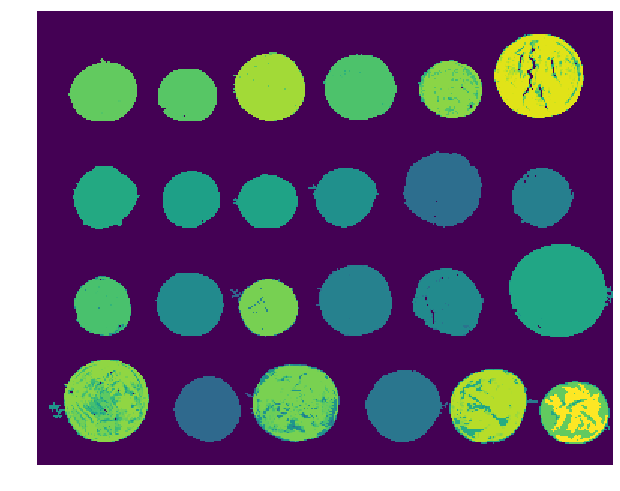

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f1a4a9cbac8>)

In [0]:
#Remove small nodes of g2 from the original image

t1par = t1.parents() - t1.num_leaves()
cond_removal = depth[t2.parent(t1par)] < 0.75
filtered_a1 = hg.reconstruct_leaf_data(t1, a1, cond_removal)

imshow(filtered_a1)


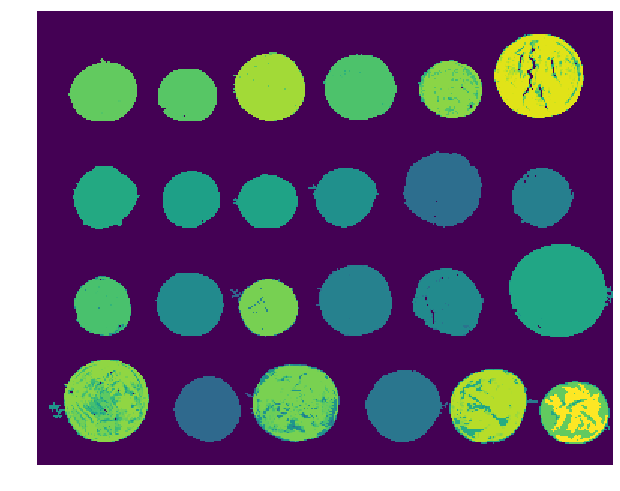

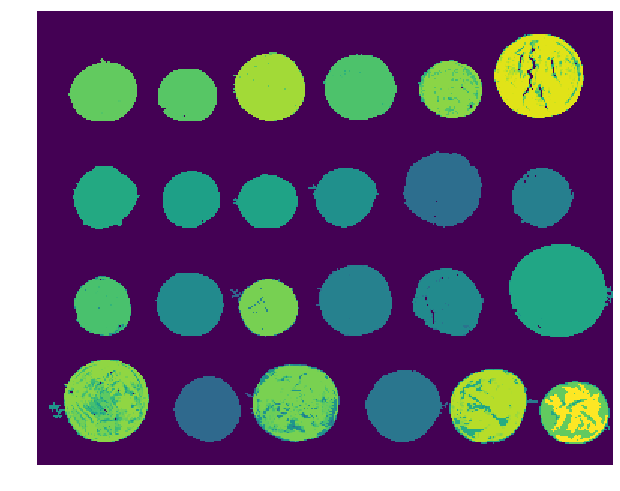

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f1a4ea58e80>)

In [0]:
# BEN: deletes  node from a tree
# there is currently a bug because simplify_tree does not correctly propagate the category of tree and the result is considered 
# as a partition tree instead of a component tree
simplified_t1, node_map = hg.simplify_tree(t1, cond_removal)
simplified_a1 = a1[node_map]

# defining cond like this is just a workaround for the bug in simplify tree
cond = np.zeros((simplified_t1.num_vertices(),), dtype=np.bool)
cond[:simplified_t1.num_leaves()] = 1
imshow(hg.reconstruct_leaf_data(simplified_t1, simplified_a1, cond))

# this also works:
imshow(simplified_a1[simplified_t1.parent(np.arange(simplified_t1.num_leaves()))].reshape(size))